# Курсовой проект Megafon

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Данные**

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

Итого, в качестве входных данных будут представлены:

- data_train.csv: id, vas_id, buy_time, target

- data_test.csv: id, vas_id, buy_time

- features.csv.zip: id, <feature_list> 


И тестовый набор:

- data_test.csv: id, vas_id, buy_time
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
- buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
- id - идентификатор абонента
- vas_id - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.

**Метрика**

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation


**Формат представления результата**

1.	Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.

2.	Код модели можно представить в виде jupyter-ноутбука. 

3.	Презентация в формате .pdf, в которой необходимо отразить:
- Информация о модели, ее параметрах, особенностях и основных результатах.
- Обоснование выбора модели и ее сравнение с альтернативами.
- Принцип составления индивидуальных предложений для выбранных абонентов.

Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

In [11]:
pip install luigi 

In [285]:
pip install implicit

In [12]:
pip install xgboost

In [13]:
! pip install catboost

In [14]:
pip install dask

In [15]:
pip install dask[dataframe] --upgrade

In [30]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,\
precision_recall_curve, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import pickle
import luigi
import gc
from datetime import datetime, date, time
from datetime import timedelta
from tqdm import tqdm

pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

from sklearn.decomposition import PCA
import scipy.sparse
from sklearn.cluster import KMeans

In [32]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import zipfile
zip_archive = zipfile.ZipFile('/content/drive/MyDrive/features.csv.zip', "r")
for file_info in zip_archive.infolist():
  zip_archive.extract(file_info, './')

In [25]:
TRAIN_PATH = "/content/drive/MyDrive/data_train.csv"
TEST_PATH = "/content/drive/MyDrive/data_test.csv"
FEATURES_PATH = "/content/features.csv"

In [26]:
data_train = pd.read_csv(TRAIN_PATH)
data_test = pd.read_csv(TEST_PATH)

Обзор train и test

In [27]:
data_train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [28]:
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB
None


In [33]:
#уменьшение потребляемой памяти (из functions.py)
data_train = reduce_mem_usage(data_train)
data_test = reduce_mem_usage(data_test)

Memory usage of dataframe is 25.38 MB
Memory usage after optimization is: 12.69 MB
Decreased by 50.0%
Memory usage of dataframe is 2.17 MB
Memory usage after optimization is: 0.95 MB
Decreased by 56.2%


In [34]:
#уникальные значения:
for col in data_train.columns[1:-1]:
    print(f'{col}  -->  {data_train[col].nunique()} + \
    {data_test[~data_test[col].isin(np.unique(data_train[col]))].shape[0]} новых значений в тесте')

id  -->  806613 +     67013 новых значений в тесте
vas_id  -->  8 +     0 новых значений в тесте
buy_time  -->  26 +     71231 новых значений в тесте


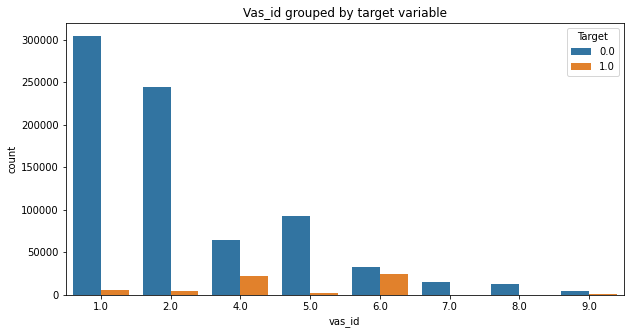

In [35]:
plt.figure(figsize=(10, 5))

sns.countplot(x="vas_id", hue=data_train['target'], data=data_train)
plt.title('Vas_id grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.savefig("vas_id-target2.png")

plt.show()

**Выводы:** различные услуги предлагались разному количеству абонентов, соотношение подключений услуг и отказов также отличается. 

На следующем графике показано соотношение подключений и отказов вне зависимости от кол-ва предложений абонентам, что впоследствии окажется более полезным признаком для модели:

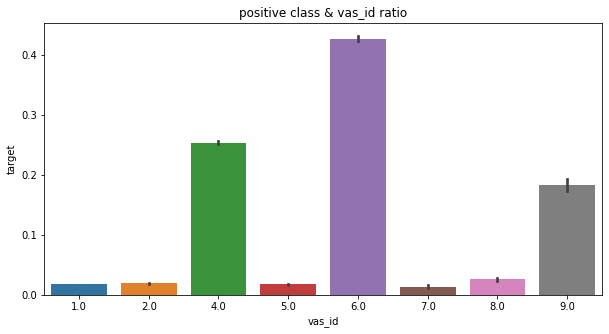

In [36]:
plt.figure(figsize=(10, 5))

sns.barplot("vas_id", 'target', data=data_train)
plt.title('positive class & vas_id ratio')
plt.savefig("vas_id-target.png")
plt.show()

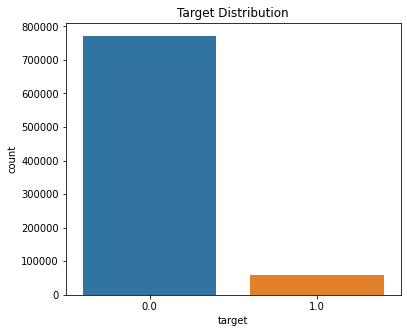

In [37]:
plt.figure(figsize=(6, 5))
plt.title('Target Distribution')

sns.countplot(x='target', data=data_train)
plt.savefig("target.png")

Наблюдается значительный дисбаланс между классами, что может негативно сказаться на результате работы модели. Добавлять синтетические данные или дубликаты строк миноритарного класса не хочется, т.к. датасет и без того огромный и тяжелый, также могут нарушиться закономерности в датах. Поэтому веса классов принято решение корректировать непосредственно в модели

#### Обзор features

Поскольку датасет весит > 20Гб, сразу уменьшим его и включим только тех пользователей, которые есть в train и test данных.

In [38]:
def process_featues(data_features, train, test):
    ids = np.unique(train['id'].append(test['id']))
    data_features = data_features[data_features['id'].isin(ids)]
    if 'Unnamed: 0' in data_features:
        data_features = data_features.drop(columns='Unnamed: 0')
    
    data_features = data_features.compute()
    # удалим признаки с единственным значением
    df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
    const = df_nunique[df_nunique ==1].index.tolist()
    data_features = data_features.drop(columns = const)
    return reduce_mem_usage(data_features)

In [39]:
data_features = dd.read_csv(FEATURES_PATH, sep ='\t')
data_features =process_featues(data_features, data_train, data_test)

Memory usage of dataframe is 1728.06 MB
Memory usage after optimization is: 528.40 MB
Decreased by 69.4%


In [40]:
data_features.corr()

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
id,1.000000,0.074840,-0.018533,-0.049811,-0.019042,-0.047225,-0.020980,-0.048451,-0.005416,-0.015210,-0.005240,-0.011587,-0.001216,-0.003679,-0.005242,-0.024060,-0.025880,0.001631,-0.000302,0.000161,-0.012227,0.002342,-0.005751,-0.019417,-0.020158,-0.001046,-0.001341,0.020735,0.031846,-0.012900,-0.016203,-0.019196,-0.018793,-0.026962,-0.001416,-0.001509,-0.013364,0.000576,-0.000429,-0.004331,0.027505,0.021553,0.019050,0.019211,0.025536,-0.013023,-0.015466,-0.008365,0.018783,0.004164,-0.003233,0.000263,-0.012622,-0.011468,-0.010804,-0.016719,-0.001796,-0.002997,-0.003312,0.001372,-0.025255,-0.110329,-0.013646,-0.013864,-0.019514,-0.010480,-0.005025,-0.010429,-0.007208,0.011375,0.007764,0.005213,0.012182,-0.001179,-0.005330,-0.004122,0.003980,0.012869,0.015264,-0.001323,-0.001250,-0.001303,-0.006782,-0.003457,-0.000642,-0.003601,-0.003258,-0.003030,-0.007343,-0.005391,-0.003748,-0.003582,-0.001365,0.000310,-0.000256,0.003758,-0.004141,-0.003020,0.002661,-0.007093,-0.004359,0.001504,-0.001568,0.001929,-0.003048,0.009817,0.000456,-0.009676,-0.005235,0.007548,0.001889,0.021544,0.018987,-0.016944,-0.019235,0.027448,0.046326,-0.005018,-0.000303,0.000020,-0.004364,-0.002011,0.019320,0.025543,0.030714,0.010822,0.018232,-0.007783,-0.004995,-0.020430,-0.024167,-0.003760,0.003719,-0.034033,-0.037130,-0.044315,-0.032439,-0.039517,-0.014309,-0.002940,-0.004201,-0.016217,-0.028622,-0.036792,0.025819,0.006187,-0.006535,0.005164,0.005219,-0.013180,-0.007232,-0.007738,-0.001104,-0.001729,0.003301,0.002257,-0.000686,-0.000811,-0.008449,0.000839,-0.002157,0.002016,-0.022922,0.042078,0.033112,0.053616,0.038834,-0.013305,-0.015462,0.007681,0.003496,-0.008548,-0.004119,-0.007720,-0.007069,-0.004269,-0.002435,-3.572096e-03,-0.003102,0.013457,0.011521,0.023971,0.020969,0.007551,-0.008367,0.019777,0.001264,-0.000113,-0.000828,-0.016292,-0.120043,-0.125707,0.033121,-0.050106,-0.061164,-0.015422,-0.107165,0.004836,-0.008694,-0.038640,0.000844,0.033718,-0.094019,0.000052,-0.044728,0.038582,0.007635,-0.010630,0.002465,-0.014136,0.002705,-0.000216,-0.006314,-6.197861e-04,0.007637,0.002412,0.006283,-0.001107,0.002661,-0.008353,-0.018766,-0.115517,-0.022566,-0.071502,-0.000391,0.004461,0.021617,0.012696,-0.002548,0.001306,0.007481,0.011321,0.006918,0.046921,0.002078,0.025633,0.018830,0.041320,0.033575,0.008622,0.033406,0.031321,0.001759,0.018031,0.016822,0.007157,-0.003176,-0.001042,-0.002227,-0.011229
buy_time,0.074840,1.000000,-0.020798,-0.056733,-0.020246,-0.050396,-0.027111,-0.061522,-0.011254,-0.022163,-0.013326,-0.024264,-0.011507,-0.003426,-0.009533,-0.012718,-0.018461,0.000974,-0.003376,-0.004625,-0.034906,-0.027668,0.000493,-0.025649,-0.007162,-0.001749,-0.002342,0.026137,-0.039176,-0.009274,0.043352,0.052105,0.053781,-0.008408,-0.002343,-0.002728,-0.014717,-0.004623,-0.023212,-0.008936,0.027655,-0.002751,0.036413,-0.010169,0.024222,-0.034550,-0.023695,-0.036358,-0.014749,0.001710,-0.000308,-0.000196,-0.052366,-0.051358,-0.059623,-0.055125,-0.020017,-0.021721,-0.023750,-0.004457,-0.097688,-0.091455,-0.011331,-0.014591,-0.043179,-0.008901,-0.011189,-0.000060,-0.000363,-0

**Выводы:**

У многих признаков высокий уровень корреляции между собой, поэтому, вероятно, некоторые из них можно удалить.

Распределение многих признаков похоже: значения 25, 50, 75 перцинтилей одинаковы, средние отличаются незначительно,  минимальные и максимальные значения отличаются.

In [41]:
tmp = data_train.merge(data_features, on='id', how = 'left')

In [42]:
tmp[tmp.columns[6:]].loc[tmp.target==1].describe() - tmp[tmp.columns[6:]].loc[tmp.target==0].describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
count,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0000,-735638.000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0000,-735638.000000,-735638.000000,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.0,-735638.0,-735638.0,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.00,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.00000,-735638.000000,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0,-735638.00000,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-7.356380e+05,-735638.00000,-735638.000000,-735638.000000,-7.356380e+05,-735638.000000,-7.356380e+05,-7.356380e+05,-735638.000000,-735638.000000,-735638.00000

In [43]:
del tmp

**Вывод:** желательно выбрать минимальное количество признаков, чтобы сделать работу модели менее ресурсозатратной. Вероятнее всего, это возможно, поскольку не все признаки репрезентативны

### Подготовка датасета

In [44]:
X = data_train.drop('target', axis=1)
y = data_train['target']

Объединим train и features и добавим новые признаки, создадим пайплайн для обработки датасета. Подавляющее большинство дат в features и train не совпадают, различных дат и обновлений профилий в features довольно мало, результат работы модели практически не меняется в зависимости от способа объединения датасетов.

In [45]:
class DataTransform(BaseEstimator, TransformerMixin):

    def __init__(self, features):
        self.data = None
        self.target = None
        self.features = features.copy()
        self.vas_id_dict1 = None
        self.vas_id_dict2 = None
        self.vas_id_dict3 = None
        self.q_list = None
        self.first_day = None


        
    def fit(self, data, target):
        self.data = data.copy()
        self.target = target.astype('int')
        X = pd.concat([data, target], axis=1)
        # доля подключений услуги по сравнению с отказами
        self.vas_id_dict1 = dict(X.groupby('vas_id')['target'].mean())
        # соотношение подключений по всем услугам
        self.vas_id_dict2 = dict(X.loc[X['target']==1]['vas_id'].value_counts(normalize=True))
        # доля предложений услуги
        self.vas_id_dict3 = dict(X['vas_id'].value_counts(normalize=True))
        #максимальные 20% значений по признакам из features
        self.q_list = [np.quantile(self.features[el], q=0.8) for el in self.features][2:]
        self.first_day = data['buy_time'].min()
        

        return self

    
    def transform(self, data):
   
        if 'Unnamed: 0' in data.columns:
            data.drop(columns='Unnamed: 0', inplace=True)
        data = reduce_mem_usage(data)
        
        # при сравнении распределения признаков в зависимости от целевой переменной в таблице выше видно, что
        # наибольшая разница наблюдается верхнем квартиле. Посчитаем значения выше 0.8 квантиля
        self.features['highest_value'] = 0
        for i, col in enumerate(self.features.columns[2:-1]):
            self.features.loc[self.features[col] > self.q_list[i], 'highest_value'] +=1
        
        
        self.features.drop_duplicates('id', keep='first', inplace=True)
        prepared_df = pd.merge(data, self.features, how='left', on='id')
        
        prepared_df.rename(columns={'buy_time_x': 'buy_time'}, inplace=True)
        

        # будем считать кол-во дней с 1го дня train периода
        prepared_df['count_days'] = (prepared_df['buy_time'] - self.first_day) //86400
        
        # доля подключений услуги по сравнению с отказами
        prepared_df['vas_id1'] = prepared_df['vas_id'].replace(self.vas_id_dict1)
        
        #prepared_df['vas_id2'] = prepared_df['vas_id'].replace(self.vas_id_dict2)
        #prepared_df['vas_id3'] = prepared_df['vas_id'].replace(self.vas_id_dict3)
       # prepared_df['date'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x))
       # prepared_df['month'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x).month)
        prepared_df['day'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x).day)
        prepared_df['weekofyear'] = prepared_df['buy_time'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).weekofyear)
        
        
        """
        Некоторым пользователям сделано несколько предложений. Сохраним информацию, какую услугу пользователю
        уже предлагали (каждую отдельно), сколько у него всего предложений, в какой последовательности предлагали
        услуги, какая разница по времени между предложениями услуг
        
        """
        tmp = prepared_df[['id', 'buy_time', 'vas_id']].merge(self.data[['id', 'buy_time', 'vas_id']],\
                                                              on=['id', 'buy_time', 'vas_id'], how='outer')
        tmp = tmp.loc[tmp['id'].isin(prepared_df['id'])]
        tmp2 = tmp.groupby('id')['vas_id'].count().reset_index()
        tmp2 = tmp2.loc[tmp2['vas_id']>1]
        tmp['buy_time'] = (tmp['buy_time'] - self.first_day) //86400
        tmp.rename(columns={'buy_time': 'count_days'}, inplace=True)
        # будем считать предложения только для тех пользователей, у которых их больше 1
        tmp = tmp.loc[tmp['id'].isin(tmp2['id'])].sort_values(['id', 'count_days']).reset_index(drop=True)
        tmp['1.0'] = 0 
        tmp['2.0'] = 0
        tmp['4.0'] = 0
        tmp['5.0'] = 0
        tmp['6.0'] = 0
        tmp['7.0'] = 0
        tmp['8.0'] = 0
        tmp['9.0'] = 0
        
        checked_id = 0
        counter = 1
        tmp['count_offers'] = 1
        tmp['time_delta'] = 0

        for i in range(tmp.shape[0]):
            if tmp.iloc[i]['id'] != checked_id:
                checked_id = tmp.iloc[i]['id']
                counter = 1   
            else:
                counter +=1
                tmp.loc[i, 'count_offers'] = counter
                tmp.loc[i, 'time_delta'] = tmp.iloc[i]['count_days'] - tmp.iloc[i-1]['count_days']
            tmp.loc[i, str(tmp.iloc[i]['vas_id'])] +=1
                
        prepared_df = prepared_df.merge(tmp[['id', 'vas_id','count_days', 'count_offers','time_delta']],\
                                        on=['id', 'vas_id','count_days'], how='left')
        prepared_df = prepared_df.merge(tmp.groupby('id').agg({'1.0': 'sum', '2.0':'sum', '4.0': 'sum', 
                    '5.0':'sum', '6.0': 'sum', '7.0':'sum', '8.0': 'sum', '9.0':'sum'}).reset_index(), on='id', how='left')
        
        #остальным пользователям проставим 1 предложение
        prepared_df['count_offers'] = prepared_df['count_offers'].fillna(1)
        prepared_df['time_delta'] = prepared_df['time_delta'].fillna(0)
        prepared_df['1.0'] = prepared_df['1.0'].fillna(0).rename('offer_1')
        prepared_df['2.0'] = prepared_df['2.0'].fillna(0).rename('offer_2')
        prepared_df['4.0'] = prepared_df['4.0'].fillna(0).rename('offer_4')
        prepared_df['5.0'] = prepared_df['5.0'].fillna(0).rename('offer_5')
        prepared_df['6.0'] = prepared_df['6.0'].fillna(0).rename('offer_6')
        prepared_df['7.0'] = prepared_df['7.0'].fillna(0).rename('offer_7')
        prepared_df['8.0'] = prepared_df['8.0'].fillna(0).rename('offer_8')
        prepared_df['9.0'] = prepared_df['9.0'].fillna(0).rename('offer_9')

        
        prepared_df.drop(['id','buy_time'], axis=1, inplace=True)
        
               
        
        return prepared_df

Изначально в пайплайн подавались все имеющиемя данные, но многие признаки оказались незначимыми для модели. Поскольку данные анонимизированы и нормализованы, сложно понять, какие из них являются категориальными и не имеют количественной взаимосвязи. Пробовала считатать признаки с < 10 уникальных значений категориальными, с 2мя значениями - бинарными.

В итоге лучший результат получился, если посчитать все анонимизированные признаки из features количественными и воспользоваться методом pca. За несколько итераций удалось значительно сократить кол-во признаков без потери качества. За 1 итерацию качественно сократить кол-во признаков до минимума не получилось, поскольку в разных сочетаниях у них разные веса, сразу из 250 признаков выделить 10 главных компонент получилось не очень хорошо.

Итого оставим:

- 1 категориальный признак
- 10 количественных признаков после РСА
- новые фичи оставим без изменений

In [46]:
#df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
#bool_features = df_nunique[df_nunique ==2].index.tolist()
#cat_features = df_nunique[df_nunique <=10].index.tolist()
#num_features = np.setdiff1d(data_features.columns[2:], cat_features)
#cat_features = np.append(np.setdiff1d(cat_features, bool_features),'vas_id')
#other_features = ['highest_value', 'count_days', 'vas_id1', 'day', 'weekofyear', 'count_offers',
#       'time_delta', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [47]:
num_features = data_features.columns[2:]
cat_features = ['vas_id']
bool_features = []
other_features = ['highest_value', 'count_days', 'vas_id1', 'day', 'weekofyear', 'count_offers',
       'time_delta', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [48]:
class PCA_transformer(BaseEstimator, TransformerMixin):

    def __init__(self, num_features):
        self.num_features = num_features
        # постепенно сократим кол-во компонент до 10
        self.steps = [80, 40, 25, 15, 10]
        self.X = None

    def fit(self, X, y=None):
        self.X = X.copy()
        return self

    def transform(self, X, y=None):
        data = X[self.num_features].copy()
        for step in self.steps:
            pca = PCA(n_components=step, svd_solver='full')
            data = pca.fit_transform(data)
        col_names = ['pca' + str(i) for i in range(len(data[0]))]

        return X.join(pd.DataFrame(data, columns=col_names))   

In [49]:
# обработка признаков разного типа в пайплайне

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)
    
    
class Bool_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.mode = None
        self.unique = None
        
    def fit(self, X, y=None):
        self.mode = X.mode()[0]
        self.unique = np.unique(X)
        return self
    
    def transform(self, X, y=None):
        for el in X:
            if el not in self.unique:
                el = self.mode
        zero = self.unique[0]
        X = np.where(X==zero, 0, 1)
        return X.reshape(len(X), 1)

In [50]:
pca_features = ['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9']

In [51]:
final_transformers = list()

#for col in bool_features:
#    bool_transformer = Pipeline([
#                ('selector', ColumnSelector(column=col)),
#                ('bool', Bool_col(key=col))
#            ])
#    final_transformers.append((col, bool_transformer))
    
cat_transformer = Pipeline([
                ('selector', ColumnSelector(cat_features)),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])
final_transformers.append(('cat', cat_transformer))
    
num_transformer = Pipeline([
                ('selector', ColumnSelector(pca_features))
            ])

final_transformers.append(('num', num_transformer))
    

other_transformer = Pipeline([
                ('selector', ColumnSelector(other_features))
            ])

final_transformers.append(('other', other_transformer))

In [52]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [53]:
# пайплайн для подготовки датасета, пока без классификатора
prep_pipeline = Pipeline([
   ('prepare', DataTransform(data_features)),
    ('pca_transformer', PCA_transformer(data_features.columns[2:])),
    ('features',feats)
])

In [54]:
prep_pipeline.fit(X, y)
data = prep_pipeline.transform(X)

Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%
Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%


In [55]:
#сохраню полученные данные
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]
df = pd.DataFrame.sparse.from_spmatrix(data, columns = cols)
df['id'] = data_train['id']

In [56]:
df.to_csv('data.csv', index=False)

### Обучение и выбор модели

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=13)

#### Сравнение 3-х моделей:

- XGBClassifier
- CatBoostClassifier
- LGBMClassifier

Подбор параметров осуществлялся с помощью GridsearchCV, например:

In [58]:
parameters = [{'max_depth': [11,12, 13] , 
               'n_estimators': [80, 100, 120],
               'num_leaves': [100, 121, 144],
               'learning_rate':[0.01, 0.045], 
               'reg_lambda': [0.2, 0.4,]}]

gridsearch = GridSearchCV(estimator= LGBMClassifier(objective='binary',
                     scale_pos_weight = 1.7935), param_grid=parameters,  
                          scoring=make_scorer(f1_score, average='macro'), cv=5)

In [59]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary',
                                      scale_pos_weight=1.7935),
             param_grid=[{'learning_rate': [0.01, 0.045],
                          'max_depth': [11, 12, 13],
                          'n_estimators': [80, 100, 120],
                          'num_leaves': [100, 121, 144],
                          'reg_lambda': [0.2, 0.4]}],
             scoring=make_scorer(f1_score, average=macro))

In [60]:
gridsearch.best_params_

{'learning_rate': 0.045,
 'max_depth': 12,
 'n_estimators': 100,
 'num_leaves': 100,
 'reg_lambda': 0.4}

#### Обучение моделей с уже подобранными параметрами:

In [126]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred, threshold = 0.5):
    threshold = np.array([threshold])
    y_pred = (y_train_pred > threshold).astype(int)
    y_test_p = (y_test_pred > threshold).astype(int)
    print('TRAIN\n\n' + classification_report(y_train_true, y_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_p))

In [96]:
%%time

model_xgb = XGBClassifier(n_estimators=100,
                          max_depth=12,
                          learning_rate=0.045,
                          reg_lambda=0.4,
                          reg_alpha=0.4,
                          scale_pos_weight=3,
                          random_state=13,
                          eval_metric='logloss',
                          importance_type='weight')
model_xgb.fit(X_train, y_train)

CPU times: user 6min 41s, sys: 616 ms, total: 6min 41s
Wall time: 6min 41s


In [120]:
xgb_train_proba = model_xgb.predict_proba(X_train)[:, 1]
xgb_test_proba = model_xgb.predict_proba(X_test)[:, 1]

In [127]:
get_classification_report(y_train, xgb_train_proba, y_test, xgb_test_proba, threshold = 0.55)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    578600
         1.0       0.59      0.76      0.66     45139

    accuracy                           0.94    623739
   macro avg       0.78      0.86      0.82    623739
weighted avg       0.95      0.94      0.95    623739

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    192867
         1.0       0.54      0.70      0.61     15047

    accuracy                           0.93    207914
   macro avg       0.76      0.82      0.79    207914
weighted avg       0.94      0.93      0.94    207914



In [128]:
%%time

model_cb = CatBoostClassifier(silent=True, iterations=160, learning_rate=0.03, depth=7, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', eval_metric='F1', early_stopping_rounds=50, 
                              random_state=42)
model_cb.fit(X_train, y_train)

CPU times: user 1min 5s, sys: 749 ms, total: 1min 6s
Wall time: 34.9 s


In [129]:
cb_train_proba = model_cb.predict_proba(X_train)[:, 1]
cb_test_proba = model_cb.predict_proba(X_test)[:, 1]

In [130]:
get_classification_report(y_train, cb_train_proba,
                          y_test, cb_test_proba, threshold=0.83)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    578600
         1.0       0.54      0.70      0.61     45139

    accuracy                           0.94    623739
   macro avg       0.76      0.83      0.79    623739
weighted avg       0.94      0.94      0.94    623739

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    192867
         1.0       0.54      0.70      0.61     15047

    accuracy                           0.94    207914
   macro avg       0.76      0.83      0.79    207914
weighted avg       0.94      0.94      0.94    207914



In [131]:
%%time

model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 1.7935,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

CPU times: user 16.3 s, sys: 72.7 ms, total: 16.3 s
Wall time: 16.3 s


In [132]:
lgb_train_proba = model_lgb.predict_proba(X_train)[:, 1]
lgb_test_proba = model_lgb.predict_proba(X_test)[:, 1]

In [133]:
get_classification_report(y_train, lgb_train_proba,
                          y_test, lgb_test_proba, threshold=0.49)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    578600
         1.0       0.61      0.62      0.62     45139

    accuracy                           0.94    623739
   macro avg       0.79      0.80      0.79    623739
weighted avg       0.94      0.94      0.94    623739

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    192867
         1.0       0.61      0.62      0.61     15047

    accuracy                           0.94    207914
   macro avg       0.79      0.79      0.79    207914
weighted avg       0.94      0.94      0.94    207914



In [134]:
predictions = {'XGBoost': xgb_test_proba, 'CatBoost': cb_test_proba, 'LGBM': lgb_test_proba}

XGBoost : AUC_PR = 0.701
XGBoost : AUC_ROC = 0.954
CatBoost : AUC_PR = 0.702
CatBoost : AUC_ROC = 0.955
LGBM : AUC_PR = 0.711
LGBM : AUC_ROC = 0.956


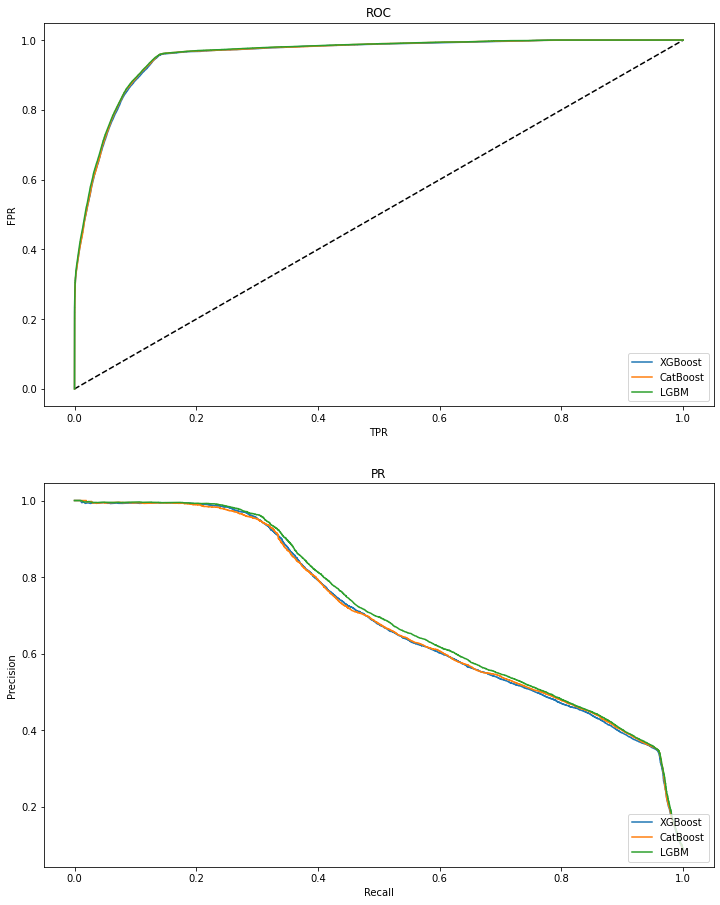

In [183]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(311)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(312)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

for key, value in predictions.items():
    fpr, tpr, roc_thresholds = roc_curve(y_test, value)
    precision, recall, pr_thresholds = precision_recall_curve(y_test, value)
    ax1.plot(fpr, tpr, label=key)
    ax2.plot(recall, precision, label=key)
    print(key, ": AUC_PR = %.3f" % auc(recall, precision))
    print(key, ": AUC_ROC = %.3f" % auc(fpr, tpr))
    
    
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");
plt.savefig("roc-pr.png")

Результаты работы моделей похожи. Выбор сделан в пользу LGBM, из-за наименьшей ее ресурсозатратности. Особенно важно при обработке большого количества данных.

In [192]:
def show_feature_importances(importances, feature_names, get_top):
    if get_top == None:
      get_top = len(feature_names)      
    feature_importances = pd.Series(importances, index=feature_names)
    feature_importances.nlargest(get_top).plot(kind='barh')
    plt.title(str(get_top) + " Feature Columns Importances")
    plt.show()

In [137]:
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]

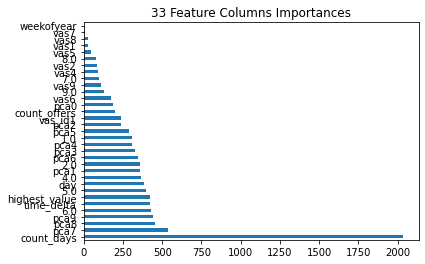

In [193]:
show_feature_importances(model_lgb.feature_importances_, cols, get_top=None)

In [194]:
# Проверим работу модели с помощью кросс-валидации:
cv_scores = cross_val_score(model_lgb, data, y, cv=6, scoring=make_scorer(f1_score, average='macro'))
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7894758476028714+-0.005984268949832327


In [196]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 6))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

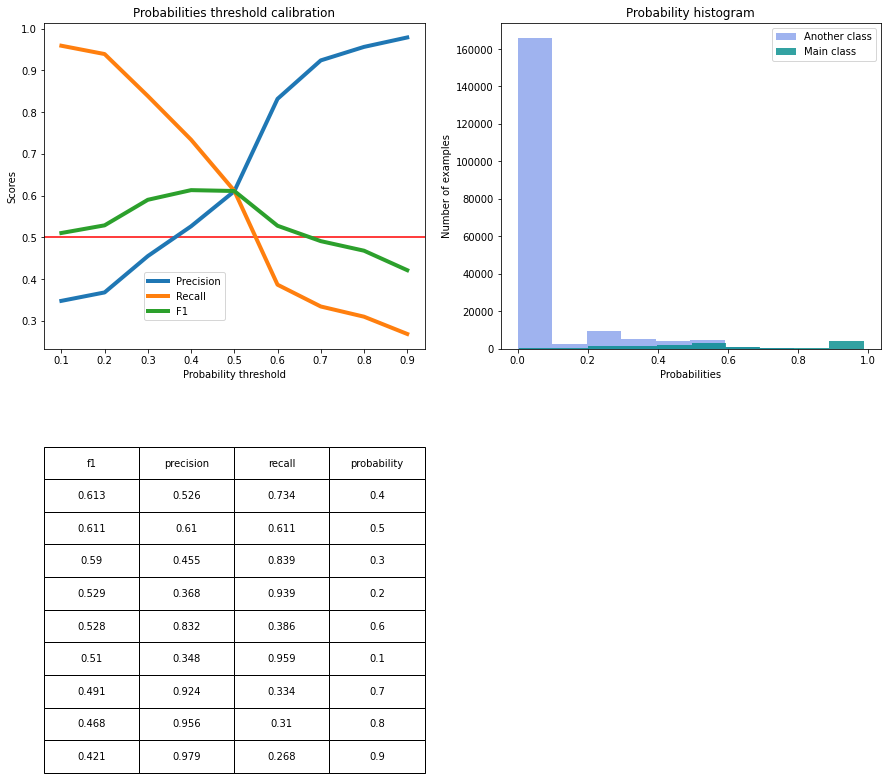

In [197]:
show_proba_calibration_plots(lgb_test_proba, y_test)

In [219]:
import seaborn

In [220]:
def plot_confusion_matrix(data, classes, title):
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))

    plt.rc('font', size=32)
    plt.rcParams["axes.labelsize"] = 26

    plt.title(title)

    seaborn.set(font_scale=2.3)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar=False, fmt='g')

    ax.set_xticklabels(classes, fontsize=22)
    ax.set_yticklabels(classes, fontsize=22)

    ax.set(ylabel="Reviewer Response", xlabel="True Value")

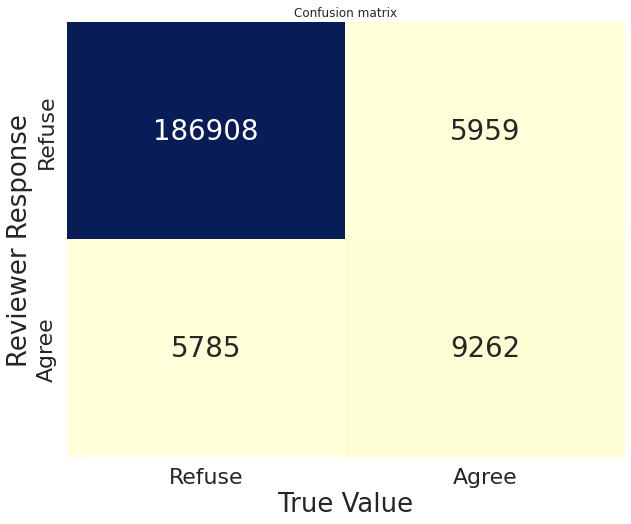

In [221]:
cnf_matrix = confusion_matrix(y_test, lgb_test_proba>0.49)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Refuse', 'Agree'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### Cохранение пайплайна

In [222]:
full_pipeline = Pipeline([
    ('prepare', DataTransform(data_features)),
    ('pca_transformer', PCA_transformer(data_features.columns[2:])),
    ('features',feats),
    ('classifier', LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2))
])

full_pipeline.fit(X, y)

Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%


Pipeline(steps=[('prepare',
                 DataTransform(features=            id    buy_time           0            1           2            3  \
13     2046132  1534712400  300.820038  1599.480835  286.879211  1585.013184   
16     2050810  1540760400  -86.209969    91.820885  -84.480789   110.333199   
19     2070757  1540760400  -96.799973  -408.179108 -110.740784  -460.786804   
20     2071522  1544994000  -94.939972  -363.699127 -108.880783  -411.226807   
22     2075318  1533502800  -75.639969   669.690918  -89...
                                                                                          'pca9']))])),
                                                ('other',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(columns=['highest_value',
                                                                                          'count_days',
                     

In [223]:
lgb_train_proba = full_pipeline.predict_proba(X)[:, 1]

Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%


In [224]:
print(classification_report(y, lgb_train_proba > 0.49))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    771467
         1.0       0.51      0.77      0.62     60186

    accuracy                           0.93    831653
   macro avg       0.75      0.86      0.79    831653
weighted avg       0.95      0.93      0.94    831653



In [225]:
with open("lgbm_pipeline.pickle", "wb") as f:
    pickle.dump(full_pipeline, f)

Запись результата

In [236]:
test = pd.read_csv(TEST_PATH, float_precision="high", encoding='utf8',sep=',')

In [237]:
with open('lgbm_pipeline.pickle', 'rb') as model_file:
            model = pickle.load(model_file)

In [238]:
test['target'] = model.predict_proba(test)[:, 1]

Memory usage of dataframe is 1.63 MB
Memory usage after optimization is: 0.68 MB
Decreased by 58.3%


In [239]:
test.to_csv('answers_test.csv', float_format='%20f', index=False, encoding='utf8',sep=',')

In [240]:
answers = pd.read_csv('answers_test.csv')
answers.head(5)

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.001059
1,2000860,4.0,1548018000,0.427791
2,1099444,2.0,1546808400,0.001043
3,1343255,5.0,1547413200,0.000804
4,1277040,2.0,1546808400,0.001043


### Персональные предложения пользователям

Каким абонентам имеет смысл предлагать услугу? Выше определен оптимальный порог для f1-macro - 0.49. Теперь определим оптимальный порог для увеличения f1 именно по миноритарному (позитивному) классу:

In [241]:
precision, recall, thresholds = precision_recall_curve(y_test, lgb_test_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score(y_test, lgb_test_proba)))

Best Threshold=0.430480, F-Score=0.615, Precision=0.543, Recall=0.709, Roc_auc=0.956


In [242]:
confusion_matrix(y_test, lgb_test_proba>0.425)

array([[183713,   9154],
       [  4318,  10729]])

Для ML оптимальным порогом определения целевого абонента является 0.425. 

Однако, важно учесть экономические и маркетинговые приоритеты компании на данном этапе. Если компании важно охватить как можно больше клиентов, не упустить никого (увеличить recall), то порог следует снизить. Если комапния не намерена тратить ресурсы на большое количество клиентов и заинтересована в том, чтобы ML-алгоритм макимально точно показал только тех клиентов, которые с максимальной вероятностью воспользуются услугой (увелилчить precision), порог следует повысить. Для того, чтобы предложить клиенту услугу, компании придется потратить деньги, поэтому обзванивать всех клиентов зачастую нецелесообразно. Чтобы определить, какой именно порог будет наиболее выгодным, можно подсчитать затраты на кандидата и прибыль с каждого true positive клиента.

В качестве упрощенного примера предположим, что затраты на кандидата = 1 доллар, а прибыль с true positive клиента = 2 доллара. Количество пороговых значений thresholds уменьшено для экономии времени.

In [243]:
expenses = 1
profit = 2
thresholds = np.linspace(0.3, 0.8, 51)

In [244]:
max_revenue = 0
best_t = 0
for t in thresholds:
    cnf_matrix = confusion_matrix(y_test, lgb_test_proba>t)
    add_summ = cnf_matrix[1,1]*profit - np.sum(cnf_matrix[:,1])*expenses
    if add_summ > max_revenue:
        max_revenue = add_summ
        best_t = t
print(f'Максимальный доход: {max_revenue} достигнут при пороге {best_t}')

Максимальный доход: 4663 достигнут при пороге 0.63


Возможно, если пользователь не согласится на эту конкретную услугу, его заинтересует другая.

Для определения, какая из 8 указанных услуг больше подойдет пользователю, можно решить с помощью мультиклассовой классификации, используя признак "vas_id" в качестве целефой переменной. Для этого возьмем предобработанные в пайплайне выше данные из data_train.csv и уберем оттуда новые признаки, зависящие непосредственно от 'vas_id'.

In [245]:
df = pd.read_csv('data.csv')

In [246]:
df = df.drop(['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0',
 '8.0', '9.0', 'vas_id1'], axis=1)

In [247]:
df['vas_id'] = data_train['vas_id']

In [248]:
df.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,highest_value,count_days,day,weekofyear,count_offers,time_delta,id,vas_id
0,7.986953e+08,-704780352.0,-124007496.0,-7760.876465,39435.148438,-2482.833252,-54917.238281,10504.490234,-625.843201,-2291.875488,40.0,70.0,16.0,37.0,1.0,0.0,540968,8.0
1,1.218489e+09,746846848.0,-193238432.0,42703.398438,-50208.601562,3923.259277,-15448.593750,-6948.459473,-5690.507812,-421.807526,23.0,7.0,15.0,28.0,1.0,0.0,1454121,4.0
2,-6.785759e+08,-264417728.0,-85790320.0,-130370.453125,118651.429688,-10249.292969,-60941.191406,-6361.102539,-6188.936523,-755.663513,5.0,35.0,12.0,32.0,1.0,0.0,2458816,1.0


In [249]:
#разделим пользователей на кластеры
# k8 = KMeans(n_clusters=8, precompute_distances = True, n_jobs=-1)
k8 = KMeans(n_clusters=8)
k8.fit(df)
df['kmeans'] =k8.predict(df)

In [250]:
result = LabelEncoder()
y = result.fit_transform(data_train['vas_id'])

In [251]:
# для обучения возьмем только пользователей, подключивших услугу
df['target'] = data_train['target']
df['vas_id'] = y

df_train = df.loc[df.target==1]

In [252]:
X = df_train.drop(['vas_id', 'target'], axis=1)
y = df_train['vas_id']

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=13)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45139, 18) (45139,) (15047, 18) (15047,)


In [254]:
X_id = X_test['id']
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

In [255]:
%%time

model_lgb = LGBMClassifier(objective='multiclass',
                     max_depth=10,
                     n_estimators=200,
                     num_leaves = 100,
                     learning_rate=0.045,
                     class_weight = 'balanced',
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

CPU times: user 20.5 s, sys: 260 ms, total: 20.8 s
Wall time: 20.9 s


In [256]:
preds = model_lgb.predict_proba(X_test)

In [257]:
df_preds = pd.DataFrame(preds, columns = ['1','2','4', '5','6','7','8', '9'])
df_preds['best_service'] = [df_preds.iloc[row].idxmax() for row in range(df_preds.shape[0])]
df_preds['id'] = X_id.values
df_preds = df_preds[['id', 'best_service','1','2','4', '5','6','7','8', '9' ]]

In [258]:
df_preds.best_service.value_counts(normalize=True)

6    0.394763
4    0.238054
1    0.101482
2    0.091846
9    0.066458
5    0.060677
8    0.032631
7    0.014089
Name: best_service, dtype: float64

Наибольший процент подключений у услуги 6, вторая по привлекательности - услуга № 4, как и в первоначальном датасете data_train.csv, а по подключению услуг 7, 8 и 9 мало наблюдений.

In [259]:
data_train[data_train.target==1]['vas_id'].value_counts()

6.0    24704
4.0    21765
1.0     5664
2.0     4797
5.0     1692
9.0     1004
8.0      347
7.0      213
Name: vas_id, dtype: int64

Оптимальной услуги для абонента 862975 является услуга № 8:

In [260]:
df_preds.loc[df_preds['id']==862975]

,id,best_service,1,2,4,5,6,7,8,9
7898,862975,8,0.078785,0.092308,0.037403,0.157592,0.007184,0.038268,0.48306,0.105401


Если идти от обратного и искать, каким абонентам продать услугу № 1, то наиболее подходящие кандидаты:

In [261]:
df_preds.sort_values('1', ascending=False).head(3)

,id,best_service,1,2,4,5,6,7,8,9
14176,3242547,1,0.777995,0.077015,0.046377,0.067038,0.002987,0.017762,0.001512,0.009314
9431,1302155,1,0.775857,0.026181,0.102592,0.053150,0.024415,0.000726,0.009244,0.007836
11011,1286899,1,0.775493,0.041363,0.111520,0.042682,0.002760,0.009823,0.001244,0.015115


По бинарной классификации (включить в выборку одинаковые данные об абонентах со всеми возможными 'vas_id') оказывается, что некоторым пользователям не интересны никакие услуги, а другим интересны сразу несколько.

In [262]:
X_train = pd.concat([df, pd.get_dummies(data_train['vas_id'].astype('str'))], axis=1).drop(['target', 'vas_id', 'id'], axis=1)
y_train = df['target']

In [263]:
X_test['vas_id'] = 1

In [264]:
part = X_test.copy()
part['vas_id'] = 2
X_test = X_test.append(part)
part['vas_id'] = 4
X_test = X_test.append(part)
part['vas_id'] = 5
X_test = X_test.append(part)
part['vas_id'] = 6
X_test = X_test.append(part)
part['vas_id'] = 7
X_test = X_test.append(part)
part['vas_id'] = 8
X_test = X_test.append(part)
part['vas_id'] = 9
X_test = X_test.append(part)

X_test = pd.concat([X_test, pd.get_dummies(X_test['vas_id'].astype('str'))], axis=1)

In [265]:
results = pd.DataFrame()
results['id'] = np.append(X_id, [X_id, X_id, X_id, X_id, X_id, X_id, X_id])
results['vas_id'] = X_test['vas_id'].values

X_test.drop('vas_id', axis = 1, inplace=True)

In [266]:
model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.045, max_depth=13, num_leaves=100,
               objective='binary', reg_lambda=0.2, scale_pos_weight=2.86)

In [267]:
binary_preds = model_lgb.predict_proba(X_test)[:, 1]

In [268]:
results['preds']= binary_preds
results.head(5)

,id,vas_id,preds
0,1946568,1,0.043521
1,3951560,1,0.035079
2,367758,1,0.001015
3,817454,1,0.985874
4,1421442,1,0.001018


In [269]:
results.loc[results['id']==817454]

,id,vas_id,preds
3,817454,1,0.985874
15050,817454,2,0.985874
30097,817454,4,0.985685
45144,817454,5,0.985874
60191,817454,6,0.985196
75238,817454,7,0.985874
90285,817454,8,0.985874
105332,817454,9,0.985874


In [270]:
results.loc[results['id']==1946568]

,id,vas_id,preds
0,1946568,1,0.043521
15047,1946568,2,0.060142
30094,1946568,4,0.456564
45141,1946568,5,0.022678
60188,1946568,6,0.693019
75235,1946568,7,0.036202
90282,1946568,8,0.044100
105329,1946568,9,0.043557


**Выводы:**
1) наблюдается значительный дисбаланс по количеству предложений разных услуг;

2) не очевиден критерий оптимально подобранной пары абонент-услуга. Если он подключил услугу, возможно, другую он подключил бы охотнее.

Определение абонентов для взаимодействия возможно методом UPLIFT. Некоторые негативно воспринимают любое взаимодействие с ними ("спящие собаки"), другие лояльны и без дополнительных затрат на их удержание.

Решение по рекомендательным системам с библиотекой imlicit, не сработало. Возможно было бы иначе, если было бы больше абонентов с различными вариантами услуг.